In [1]:
# Initial imports
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
import json

%matplotlib inline

In [2]:
# Load .env enviroment variables
from dotenv import load_dotenv
load_dotenv()

True

## Part 1 - Personal Finance Planner

In [3]:
# Set monthly household income
monthly_income = 12000

### Collect Crypto Prices Using the requests Library


In [4]:
# Current amount of crypto assets
my_btc = 1.2
my_eth = 5.3

In [5]:
# Crypto API URLs
btc_url = "https://api.alternative.me/v2/ticker/Bitcoin/?convert=USD"
eth_url = "https://api.alternative.me/v2/ticker/Ethereum/?convert=USD"

In [6]:
# Fetch current BTC price
btc_response = requests.get(btc_url).json()
#print(json.dumps(btc_response,indent=4))
btc_price = btc_response["data"]["1"]["quotes"]["USD"]["price"] 

# Fetch current ETH price
eth_response = requests.get(eth_url).json()
#print(json.dumps(eth_response,indent=4))
eth_price = eth_response["data"]["1027"]["quotes"]["USD"]["price"]

# Compute current value of my crpto
my_btc_value = my_btc * btc_price
my_eth_value = my_eth * eth_price

# Print current crypto wallet balance
print(f"The current value of your {my_btc} BTC is ${my_btc_value:0.2f}")
print(f"The current value of your {my_eth} ETH is ${my_eth_value:0.2f}")

The current value of your 1.2 BTC is $13868.89
The current value of your 5.3 ETH is $2058.63


### Collect Investments Data Using Alpaca: SPY (stocks) and AGG (bonds)

In [7]:
# Current amount of shares
my_agg = 200
my_spy = 50

In [8]:
# Set Alpaca API key and secret
alpaca_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object
api = tradeapi.REST(
    alpaca_key,
    alpaca_secret_key,
    api_version='v2')

In [9]:
# Format current date as ISO format
today = pd.Timestamp("2020-10-9",tz='America/New_York').isoformat()

# Set the tickers
tickers = ["AGG", "SPY"]

# Set timeframe to '1D' for Alpaca API
timeframe = "1D"

# Get current closing prices for SPY and AGG
df_tickers = api.get_barset(
    tickers,
    timeframe,
    start=today,
    end=today
).df

df_tickers.index = df_tickers.index.date

# Pick AGG and SPY close prices
agg_close_price = float(df_tickers['AGG']['close'])
spy_close_price = float(df_tickers['SPY']['close'])

# Print AGG and SPY close prices
print(f"Current AGG closing price: ${agg_close_price}")
print(f"Current SPY closing price: ${spy_close_price}")

Current AGG closing price: $117.705
Current SPY closing price: $346.84


In [10]:
# Compute the current value of shares
my_spy_value = my_spy * spy_close_price
my_agg_value = my_agg * agg_close_price

# Print current value of share
print(f"The current value of your {my_spy} SPY shares is ${my_spy_value:0.2f}")
print(f"The current value of your {my_agg} AGG shares is ${my_agg_value:0.2f}")

The current value of your 50 SPY shares is $17342.00
The current value of your 200 AGG shares is $23541.00


### Savings Health Analysis

In [11]:
# Create savings DataFrame
crypto = my_btc_value + my_eth_value
shares = my_spy_value + my_agg_value

df_savings = pd.DataFrame({'Amount':[crypto,shares]},
             index=['Crypto','Shares'])

# Display savings DataFrame
display(df_savings)

,Amount
Crypto,15927.518
Shares,40883.000


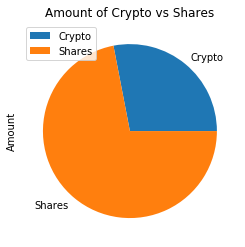

In [12]:
# Plot savings pie chart
df_savings.plot.pie(y='Amount',title='Amount of Crypto vs Shares')

In [13]:
# Set ideal emergency fund
emergency_fund = monthly_income * 3

# Calculate total amount of savings
total_savings = crypto + shares

# Validate saving health
if total_savings >= emergency_fund:
    print("Congratulations! You have enough money in your emergency fund.")
else:
    print(f"You don't quite have enough savings for an ideal emergency fund. You have {total_savings} and an ideal amount is {emergency_fund}")

Congratulations! You have enough money in your emergency fund.


## Part 2 - Retirement Planning

### Monte Carlo Simulation

In [14]:
# Set start and end dates of five years back from today.
# Sample results may vary from the solution based on the time frame chosen
start_date = pd.Timestamp('2015-10-12', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2020-10-12', tz='America/New_York').isoformat()

In [15]:
# Get 5 years' worth of historical data for SPY and AGG
tickers = ['SPY','AGG']

timeframe = '1D'

df_stock_data = api.get_barset(
    tickers,
    timeframe,
    start = start_date,
    end = end_date
).df
# Display sample data
df_stock_data.head()

AGG                                       \
                             open      high       low   close   volume   
2015-10-12 00:00:00-04:00  109.48  109.6500  109.3300  109.63   816909   
2015-10-13 00:00:00-04:00  109.62  109.7500  109.4900  109.63  1360561   
2015-10-14 00:00:00-04:00  109.83  110.0500  109.7251  110.03  3785661   
2015-10-15 00:00:00-04:00  109.93  110.0499  109.7900  109.89  1792325   
2015-10-16 00:00:00-04:00  109.90  109.9400  109.7800  109.78  1497588   

                              SPY                                    
                             open    high     low   close    volume  
2015-10-12 00:00:00-04:00  201.42  201.76  200.91  201.55  42032769  
2015-10-13 00:00:00-04:00  200.65  202.16  200.05  200.22  72076783  
2015-10-14 00:00:00-04:00  200.18  200.87  198.94  199.27  82856686  
2015-10-15 00:00:00-04:00  200.08  202.34  199.64  202.33  96008389  
2015-10-16 00:00:00-04:00  202.83  203.29  201.92  203.14  79323870

In [16]:
# Configuring a Monte Carlo simulation to forecast 30 years cumulative returns
MC_stock_data = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [0.4,0.6],
    num_simulation = 500,
    num_trading_days = 252*30)

# Printing the simulation input data
MC_stock_data.portfolio_data.head()

# Running a Monte Carlo simulation to forecast 30 years cumulative returns
MC_stock_data.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.004396,1.000930,1.008412,1.006051,0.999949,1.002122,1.014193,1.015227,1.000092,0.999610,...,0.996264,1.005809,1.001408,1.001917,0.995957,0.999210,0.984526,1.001014,0.992042,0.990821
2,1.000418,0.996003,1.014693,1.016803,1.006588,1.013107,1.012730,1.017183,1.002197,0.994348,...,0.991329,1.006746,0.987552,0.999791,1.004420,0.989664,0.986869,1.003958,0.994418,0.997871
3,0.996891,0.997638,0.997198,1.016157,1.005698,1.001969,1.011963,1.019967,1.006574,0.989824,...,0.994088,1.020567,0.976002,1.005076,0.985245,0.985505,0.986045,0.987674,1.002970,0.999582
4,0.993448,0.993755,0.996728,1.014509,0.993628,1.000995,1.002746,1.017476,1.013633,0.988707,...,0.989874,1.020614,0.974954,0.998140,0.984071,0.984405,0.981230,0.981261,1.002368,1.010321
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7556,5.762437,16.122572,12.020716,38.007720,14.854877,27.012172,9.441579,31.292493,10.158941,16.408501,...,6.649636,13.639349,41.248070,8.431334,11.058990,6.686634,5.332064,19.023211,26.724846,26.345819
7557,5.782041,16.299767,12.034634,37.945901,14.823646,27.387503,9.551775,31.231350,10.169403,16.402179,...,6.637327,13.861886,41.520971,8.375750,10.986234,6.771412,5.282223,18.986927,26.613027,26.288124
7558,5.756410,16.149357,12.174342,37.528292,14.936261,27.420806,9.620682,31.212757,10.195176,16.447423,...,6.640423,13.790855,42.189789,8.418630,11.004084,6.715299,5.345501,19.089447,26.467569,25.927119
7559,5.785535,16.071314,12.192412,37.751194,15.006347,27.479087,9.657626,30.831168,10.274786,16.436324,...,6.672917,13.677617,42.332850,8.439085,11.089260,6.718054,5.388894,19.020066,26.488524,25.614573


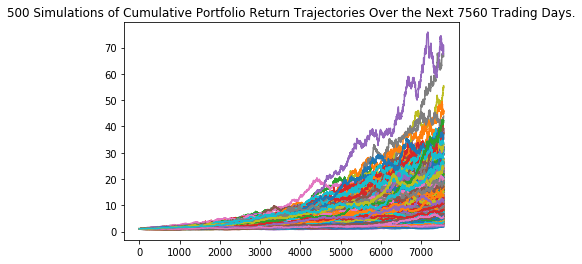

In [17]:
# Plot simulation outcomes
MC_stock_data.plot_simulation()

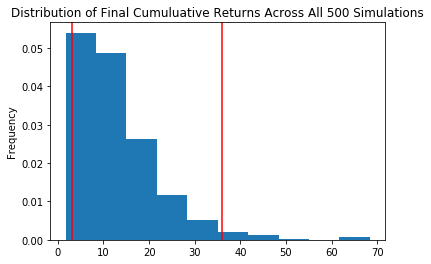

In [18]:
# Plot probability distribution and confidence intervals
MC_stock_data.plot_distribution()

In [19]:
# Fetch summary statistics from the Monte Carlo simulation results
tbl = MC_stock_data.summarize_cumulative_return()
print(tbl)

count           500.000000
mean             13.053908
std               8.984452
min               1.686657
25%               6.671052
50%              11.051846
75%              16.916003
max              68.402983
95% CI Lower      3.154586
95% CI Upper     36.053440
Name: 7560, dtype: float64


### Given an initial investment of 20,000 dollars, what is the expected portfolio return in dollars at the 95% lower and upper confidence intervals?

In [20]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
ci_lower = round(tbl[8]*initial_investment,2)
ci_upper = round(tbl[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 30 years will end within in the range of $63091.71 and $721068.79


### How would a 50% increase in the initial investment amount affect the expected portfolio return in dollars at the 95% lower and upper confidence intervals?

In [21]:
# Set initial investment
initial_investment = 20000 * 1.5

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $30,000
ci_lower = round(tbl[8]*initial_investment,2)
ci_upper = round(tbl[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $30000.0 in the portfolio over the next 30 years will end within in the range of $94637.57 and $1081603.19


## Optional Challenge - Early Retirement

### Five Years Retirement Option

In [22]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns
#Let's try a more aggressive portfolio with only 10% in bonds and 90% in stocks this time!

MC_retire_early = MCSimulation(
    portfolio_data=df_stock_data,
    weights = [0.1,0.9],
    num_simulation = 500,
    num_trading_days = 252*5)

MC_retire_early.portfolio_data.head()

AGG                                       \
                             open      high       low   close   volume   
2015-10-12 00:00:00-04:00  109.48  109.6500  109.3300  109.63   816909   
2015-10-13 00:00:00-04:00  109.62  109.7500  109.4900  109.63  1360561   
2015-10-14 00:00:00-04:00  109.83  110.0500  109.7251  110.03  3785661   
2015-10-15 00:00:00-04:00  109.93  110.0499  109.7900  109.89  1792325   
2015-10-16 00:00:00-04:00  109.90  109.9400  109.7800  109.78  1497588   

                                           SPY                          \
                          daily_return    open    high     low   close   
2015-10-12 00:00:00-04:00          NaN  201.42  201.76  200.91  201.55   
2015-10-13 00:00:00-04:00     0.000000  200.65  202.16  200.05  200.22   
2015-10-14 00:00:00-04:00     0.003649  200.18  200.87  198.94  199.27   
2015-10-15 00:00:00-04:00    -0.001272  200.08  202.34  199.64  202.33   
2015-10-16 00:00:00-04:00    -0.001001  202.83  203.29  201.92  203.14   

                                                  
                             volume daily_return  
2015-10-12 00:00:00-04:00  42032769          NaN  
2015-10-13 00:00:00-04:00  72076783    -0.006599  
2015-10-14 00:00:00-04:00  82856686    -0.004745  
2015-10-15 00:00:00-04:00  96008389     0.015356  
2015-10-16 00:00:00-04:00  79323870     0.004003

In [23]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
MC_retire_early.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.022123,1.021080,0.999800,1.006484,1.005156,0.998878,0.996907,0.994178,0.998133,1.012983,...,0.981597,1.017694,1.015563,0.994622,0.986885,1.019675,0.993055,0.974354,1.011239,0.995054
2,1.020004,1.001989,0.998533,0.996837,1.003929,1.024785,1.006918,0.996595,0.995734,1.024618,...,0.988331,1.023801,1.018941,1.011343,0.986025,1.017430,0.999775,0.979311,1.005842,0.995966
3,1.005278,0.997820,1.001189,1.019461,1.020218,1.027603,1.005637,1.003744,0.982192,1.017564,...,0.977237,1.016567,1.031472,1.025901,1.000607,1.029842,0.997739,0.985422,1.001777,1.003477
4,1.007950,1.014741,0.994665,1.027683,1.036917,1.035043,1.007604,1.007117,0.974606,1.016105,...,0.974884,1.023608,1.025148,1.034184,1.001800,1.043838,1.007532,0.992087,1.008838,1.004990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,1.826065,1.263626,1.100897,1.126268,0.897078,1.011218,1.246709,1.456978,1.528042,1.468787,...,2.272755,1.454974,2.380253,1.960616,1.612584,1.203125,2.608599,1.876868,1.337740,0.938739
1257,1.807159,1.259367,1.108402,1.138875,0.901459,0.996428,1.267995,1.470093,1.511323,1.454779,...,2.271884,1.454959,2.384817,1.941223,1.642173,1.219863,2.588354,1.879550,1.356142,0.940240
1258,1.808204,1.258014,1.121887,1.136980,0.903242,1.015212,1.280431,1.481392,1.497553,1.443955,...,2.251898,1.454349,2.405531,1.937371,1.632987,1.214678,2.613505,1.872252,1.346049,0.936335
1259,1.798164,1.267954,1.101878,1.144023,0.914337,0.998446,1.283952,1.475983,1.504452,1.440449,...,2.298942,1.436690,2.420741,1.960801,1.646133,1.212779,2.634979,1.880231,1.380837,0.936369


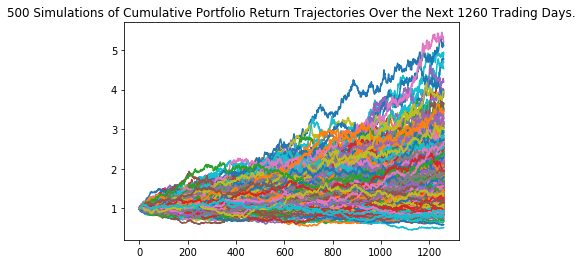

In [24]:
MC_retire_early.plot_simulation()

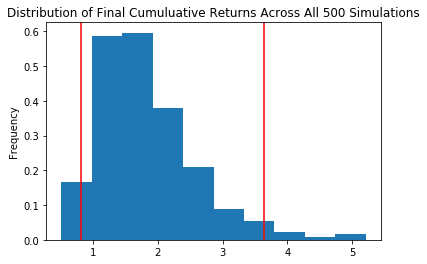

In [25]:
MC_retire_early.plot_distribution()

In [26]:
retire_early_tbl = MC_retire_early.summarize_cumulative_return()
retire_early_tbl

count           500.000000
mean              1.834732
std               0.760170
min               0.511952
25%               1.295541
50%               1.667724
75%               2.227163
max               5.209850
95% CI Lower      0.812402
95% CI Upper      3.639772
Name: 1260, dtype: float64

In [27]:
# Set initial investment
initial_investment = 195000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
ci_lower = round(retire_early_tbl[8]*initial_investment,2)
ci_upper = round(retire_early_tbl[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $195000 in the portfolio over the next 5 years will end within in the range of $158418.33 and $709755.59


In [28]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns
#Let's try a more aggressive portfolio with only 40% in bonds and 60% in stocks this time!

MC_retire_early_2 = MCSimulation(
    portfolio_data=df_stock_data,
    weights = [0.4,0.6],
    num_simulation = 500,
    num_trading_days = 252*5)

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

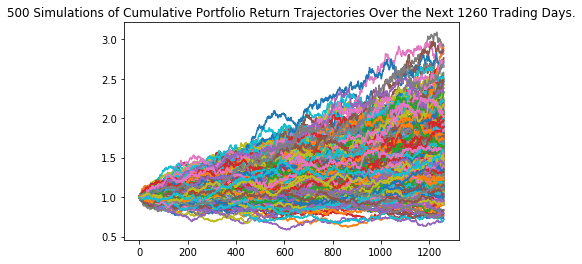

In [29]:
MC_retire_early_2.plot_simulation()

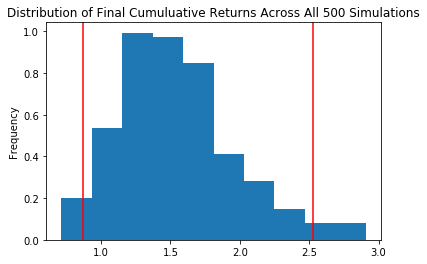

In [30]:
MC_retire_early_2.plot_distribution()

In [31]:
retire_early_2_tbl = MC_retire_early_2.summarize_cumulative_return()
retire_early_2_tbl

count           500.000000
mean              1.544908
std               0.421341
min               0.714098
25%               1.239989
50%               1.495239
75%               1.762015
max               2.907769
95% CI Lower      0.868615
95% CI Upper      2.524248
Name: 1260, dtype: float64

In [32]:
# Set initial investment
initial_investment = 195000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
ci_lower = round(retire_early_2_tbl[8]*initial_investment,2)
ci_upper = round(retire_early_2_tbl[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $195000 in the portfolio over the next 5 years will end within in the range of $169379.96 and $492228.31
